# Openning data set and splitting to test, train, val

In [1]:
# import splitfolders

In [2]:
# input_folder = "dataset"
# output_folder = "processed_data"
# splitfolders.ratio(input_folder, output_folder, seed=42, ratio=(.8,.1,.1))

Copying files: 147 files [00:00, 409.90 files/s]


In [3]:
# help(splitfolders.ratio)

Help on function ratio in module splitfolders.split:

ratio(input, output='output', seed=1337, ratio=(0.8, 0.1, 0.1), group_prefix=None, move=False)



# Importing required packages

In [4]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# Preprocessing

In [5]:
img_height, img_weight = (224,224)
batch_size = 32

train_data_dir = r"processed_data\train"
valid_data_dir = r"processed_data\val"
test_data_dir = r"processed_data\test"

In [6]:
train_datagen =  ImageDataGenerator(preprocessing_function=preprocess_input,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    validation_split=0.4) # set as training data

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_weight),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training') # set as training data

valid_generator = train_datagen.flow_from_directory(valid_data_dir,
                                                    target_size=(img_height, img_weight),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='validation') # set as validation data

test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                    target_size=(img_height, img_weight),
                                                    batch_size=1,
                                                    class_mode='categorical',
                                                    subset='validation') # set as validation data

Found 71 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
Found 5 images belonging to 2 classes.


In [7]:
x, y = test_generator.next()
x.shape

(1, 224, 224, 3)

# Modeling and Fitting

In [8]:
base_model = ResNet50(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(train_generator, validation_data=valid_generator, epochs = 10)

Epoch 1/10
3/3 [==============================] - 13s 895ms/step - loss: 3.3509 - accuracy: 0.5915 - val_loss: 1.1492 - val_accuracy: 0.7500
Epoch 2/10
3/3 [==============================] - 1s 173ms/step - loss: 0.7622 - accuracy: 0.8451 - val_loss: 0.1600 - val_accuracy: 1.0000
Epoch 3/10
3/3 [==============================] - 1s 176ms/step - loss: 0.0342 - accuracy: 0.9859 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 4/10
3/3 [==============================] - 1s 216ms/step - loss: 0.0274 - accuracy: 0.9859 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - 1s 322ms/step - loss: 0.0456 - accuracy: 0.9859 - val_loss: 4.4283e-05 - val_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 1s 196ms/step - loss: 0.0446 - accuracy: 0.9859 - val_loss: 7.1526e-07 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 1s 173ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 8.8511e-06 - val_accuracy: 1.0000
Epoch 8

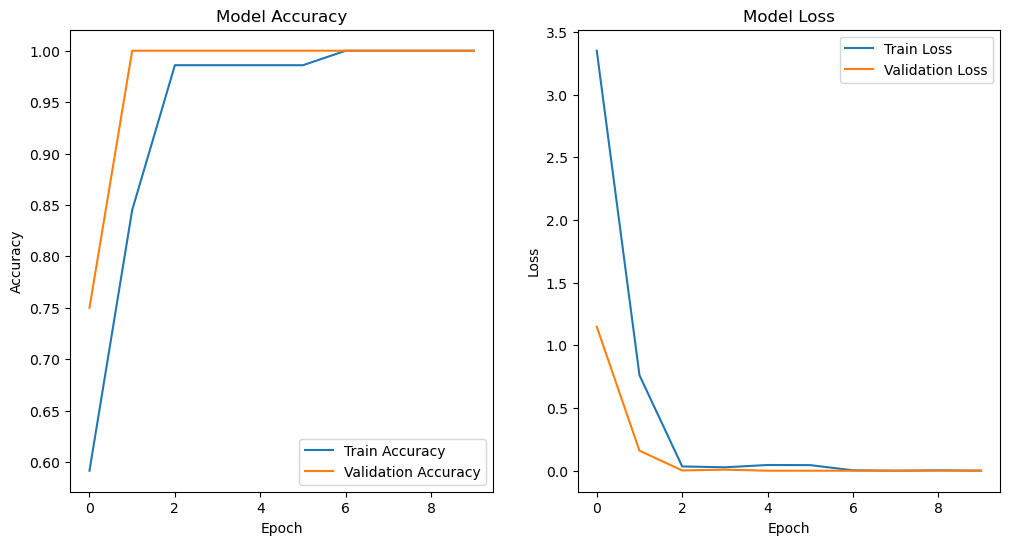

In [9]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [13]:
import os # Create the directories if they do not exist 
# os.makedirs('model/resnet50', exist_ok=True)
model.save('model/resnet50/copra_mold_identification_resnet50.h5')

C:\Users\Jamith\anaconda3\envs\copra\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [11]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest Accuracy:', test_acc*100)

5/5 - 0s - loss: 0.0183 - accuracy: 1.0000

Test Accuracy: 100.0


# Testing

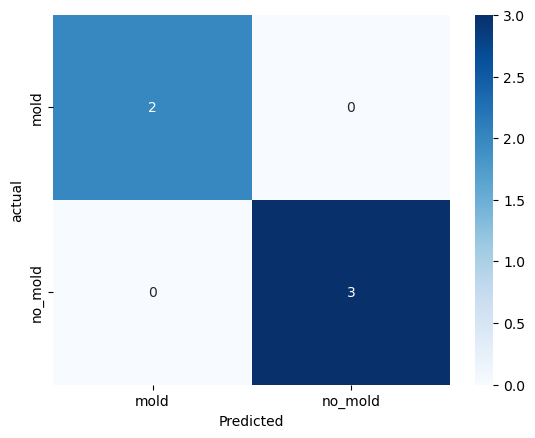

test accuracy : 100.0


In [14]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model('model/resnet50/copra_mold_identification_resnet50.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    X_test, Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)
    
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class', 'actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, cmap='Blues', annot=True, fmt='d')
plt.show()
print('test accuracy : {}'.format(np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100))

# Convert to TensorFlow Lite

In [15]:
# Load your Keras model
model = tf.keras.models.load_model('model/resnet50/copra_mold_identification_resnet50.h5')

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('model/resnet50/copra_model_identification_resnet50.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\Jamith\AppData\Local\Temp\tmpni8q_8dt\assets


C:\Users\Jamith\anaconda3\envs\copra\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# Optimize the TFLite Model

In [16]:
# Post-training quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# Save the quantized TFLite model
with open('model/resnet50/copra_mold_identification_resnet50_quant.tflite', 'wb') as f:
    f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Jamith\AppData\Local\Temp\tmpia4dsd6f\assets


INFO:tensorflow:Assets written to: C:\Users\Jamith\AppData\Local\Temp\tmpia4dsd6f\assets
C:\Users\Jamith\anaconda3\envs\copra\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
